In [ ]:
!pip3 install xgboost shap lime optuna

# 0. Dataset
Возьмём датасет с выплатами по медицинской страховке и физическими данными о клиентах

In [1]:
import numpy as np
import pandas as pd

In [7]:
df = pd.read_csv('insurance.csv')
df

age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]

В датасете есть категориальные признаки, поэтому заменим их числовыми значениями

In [3]:
from sklearn.preprocessing import LabelEncoder

In [8]:
sex_enc = LabelEncoder()
smoker_enc = LabelEncoder()
region_enc = LabelEncoder()
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [9]:
df['sex'] = sex_enc.fit_transform(df['sex'])
df['smoker'] = smoker_enc.fit_transform(df['smoker'])
df['region'] = region_enc.fit_transform(df['region'])
df

age  sex     bmi  children  smoker  region      charges
0      19    0  27.900         0       1       3  16884.92400
1      18    1  33.770         1       0       2   1725.55230
2      28    1  33.000         3       0       2   4449.46200
3      33    1  22.705         0       0       1  21984.47061
4      32    1  28.880         0       0       1   3866.85520
...   ...  ...     ...       ...     ...     ...          ...
1333   50    1  30.970         3       0       1  10600.54830
1334   18    0  31.920         0       0       0   2205.98080
1335   18    0  36.850         0       0       2   1629.83350
1336   21    0  25.800         0       0       3   2007.94500
1337   61    0  29.070         0       1       1  29141.36030

[1338 rows x 7 columns]

Разобъём данные на обучающую, валидационную и тестовую выборку.

In [27]:
X = df.drop('charges', axis=1)
y = df['charges']

In [11]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size=0.3, random_state=69420)
X_train, X_val, y_train, y_val = \
  train_test_split(X_train, y_train, test_size=0.3, random_state=69420)

# 1. XGBoost
Используем XGBoost регрессор в качестве модели предсказания.
Попросим optuna подобрать параметры, которые уменьшают среднюю абс. ошибку
на валидационных данных.

In [50]:
from xgboost import XGBRegressor
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from sklearn.metrics import mean_absolute_error

In [43]:
def objective(trial):
  n_estimators = trial.suggest_int('n_estimators', 2, 100)
  max_depth = trial.suggest_int('max_depth', 2, 500)
  max_leaves = trial.suggest_int('max_leaves', 1, 1000)

  xgbr = XGBRegressor(n_estimators=n_estimators,
                      max_depth=max_depth,
                      max_leaves=max_leaves,
                      learning_rate=0.1,
                      random_state=69420)

  xgbr.fit(X_train.to_numpy(), y_train.to_numpy())
  pred = xgbr.predict(X_val.to_numpy())
  return mean_absolute_error(pred, y_val.to_numpy())

In [44]:
study = optuna.create_study(direction='minimize',
                            sampler=TPESampler(),
                            pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=1000)

[I 2025-05-30 10:17:52,136] A new study created in memory with name: no-name-5234b760-7f40-4986-bd1f-ddb5fde0962a
[I 2025-05-30 10:17:52,468] Trial 0 finished with value: 2834.9923221703457 and parameters: {'n_estimators': 97, 'max_depth': 206, 'max_leaves': 774}. Best is trial 0 with value: 2834.9923221703457.
[I 2025-05-30 10:17:52,557] Trial 1 finished with value: 2841.6026007957907 and parameters: {'n_estimators': 37, 'max_depth': 282, 'max_leaves': 842}. Best is trial 0 with value: 2834.9923221703457.
[I 2025-05-30 10:17:52,852] Trial 2 finished with value: 2833.0635905749 and parameters: {'n_estimators': 85, 'max_depth': 65, 'max_leaves': 593}. Best is trial 2 with value: 2833.0635905749.
[I 2025-05-30 10:17:53,025] Trial 3 finished with value: 2814.484211459436 and parameters: {'n_estimators': 61, 'max_depth': 336, 'max_leaves': 755}. Best is trial 3 with value: 2814.484211459436.
[I 2025-05-30 10:17:53,150] Trial 4 finished with value: 2814.478621535059 and parameters: {'n_esti

Строим модель XGBoost регрессора по наилучшим параметрам

In [46]:
best = study.best_params
xgbr = XGBRegressor(n_estimators=best['n_estimators'],
                    max_depth=best['max_depth'],
                    max_leaves=best['max_leaves'],
                    learning_rate=0.1,
                    random_state=69420)
xgbr.fit(X_train.to_numpy(), y_train.to_numpy())
pred = xgbr.predict(X_test)

Строим плотность предсказания XGBoost регрессора

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

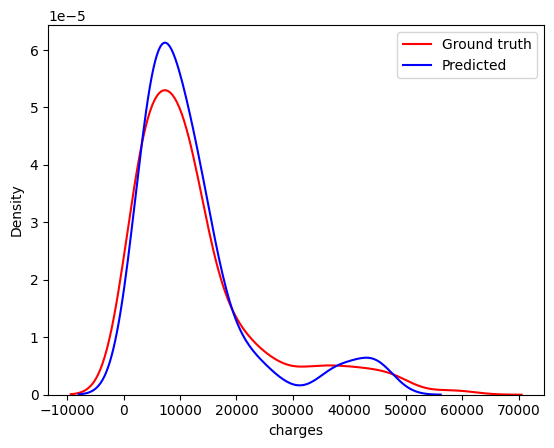

In [49]:
sns.kdeplot(y_test, label='Ground truth', color='red')
sns.kdeplot(pred, label='Predicted', color='blue')
plt.legend()
plt.show()

# 2. SHAP
Используем SHAP для глобальной интерпретации

In [52]:
import shap

In [56]:
# @grok, pls explain
explainer = shap.TreeExplainer(xgbr)
shap_values = explainer.shap_values(X_test)

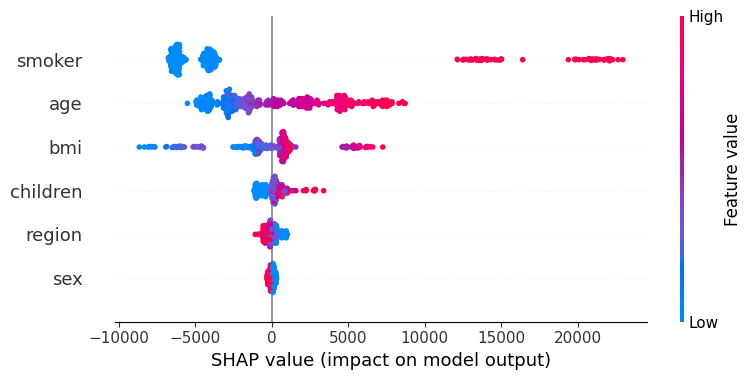

In [57]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

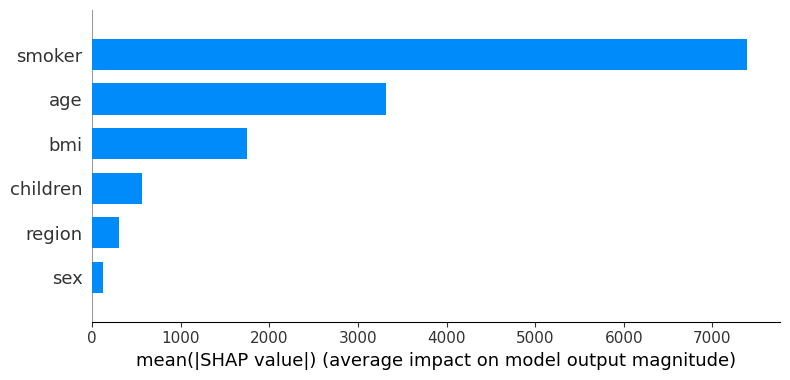

In [58]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type='bar')

Отчетливо видно, что признак курильщика является важным для предсказания затрат по страховке, на втором месте стоит возраст клиента, на третьем -- индекс массы тела.

Посмотрим, как взаимосвязаны возраст и ИМТ.

**Ответ**: Не очень. Градация цветов индексов между значениями подтверждает, что
между этими признаками нет свзяи

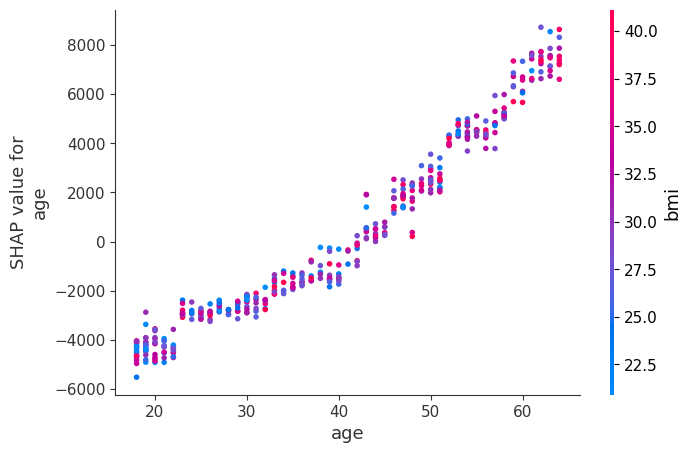

In [59]:
shap.dependence_plot('age', shap_values, interaction_index='bmi', features=X_test)

А как теперь взаимодействуют признаки курильщика и ИМТ?

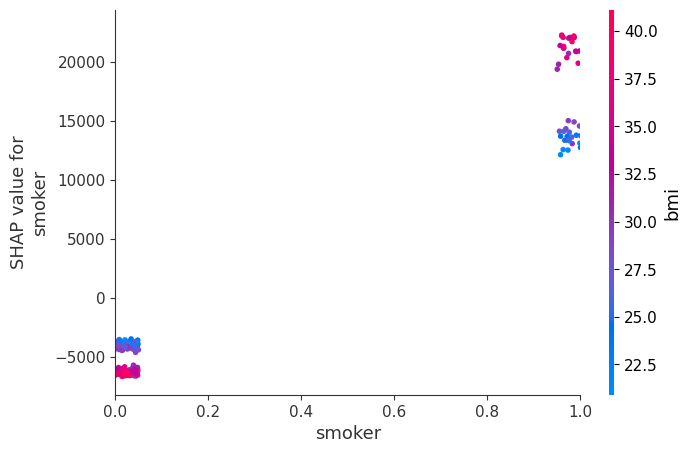

In [62]:
shap.dependence_plot('smoker', shap_values, interaction_index='bmi', features=X_test,
                     x_jitter=0.1, xmin=0, xmax=1)
# x_jitter помогает с читаемостью для бинарных признаков

**Ответ**: Для курильщиков разница между значениями SHAP гораздо больше для людей с разным ИМТ. так что если человек курит, то его ИМТ может стать очень важным фактором при определении суммы мед. услуг по страховке.

Для некурящих людей разный ИМТ не так сильно меняет значение SHAP, но интересно, что некурящие люди с более высоким ИМТ снижают значение SHAP (а значит, и сумму по страховке) немного больше, чем некурящие люди с более низким ИМТ.

Теперь посмотрим, какие признаки повлияли на одном из значений тестовой выборки

In [67]:
shap.initjs()
index = [0]
shap.force_plot(explainer.expected_value, shap_values[index], X_test.iloc[index,:],
                feature_names=X_test.columns)

В данном случае позитивно сыграло количество детей у клиента

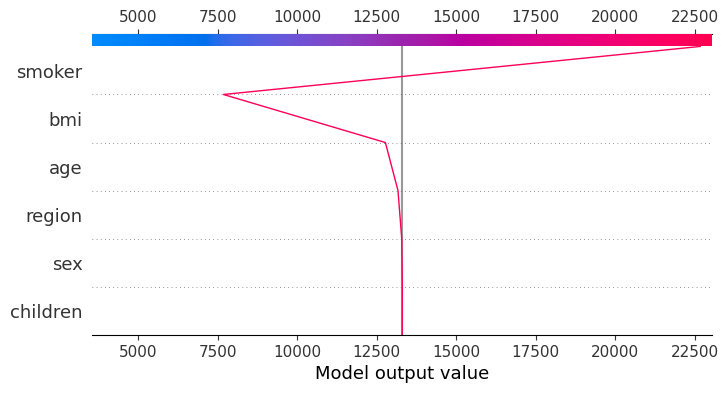

In [84]:
shap.initjs()
shap.decision_plot(explainer.expected_value, shap_values[14],
                   feature_names=list(X_test.columns))

Decision диаграмма показывает то же самое, что и Force диаграмма, только более развёрнуто по каждому из признаков.

Для другого клиента на итоговую сумму по страховке сыграло то, что он курильщик.

# 3. LIME

Создадим LIME пояснятор по тренировочным данным, на которых обучалась модель

In [88]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    mode='regression',
    random_state=69420
)

Сначала создадим объяснение для какого-то из тестовых примеров

In [92]:
test_exp = explainer.explain_instance(X_test.iloc[0].values, xgbr.predict, num_features=6)
test_exp.show_in_notebook(show_all=True)

In [123]:
xgbr.predict(X_test.iloc[0].to_numpy().reshape(1, 6))

array([8744.762], dtype=float32)

Из этого примера видно, что предсказанная сумма по страховке существенно
уменьшается, в то время как большое количество детей и средний возраст вносят
вклад в увеличении этой суммы.

А теперь поколдуем над данными: что будет, если предыдущий клиент закурил бы и детей было меньше?

In [103]:
sample = X_test.iloc[0].copy()
sample['smoker'] = 1.0
sample['children'] = 1.0

In [104]:
test_exp = explainer.explain_instance(sample.values, xgbr.predict, num_features=6)
test_exp.show_in_notebook(show_all=True)

Теперь предсказанное значение у этого клиента будет точно большим за счёт того,что этот клиент -- курильщик, а количество детей почти совсем не влияет.

In [119]:
xgbr.predict(sample.to_numpy().reshape(1,6))

array([22481.576], dtype=float32)

Была сумма 8744, а стала 22481, что довольно существенно.

**Выводы**: выводы сделаны -- если человек курит, значит у него будут больше затраты по мед. страховке.

Что интересно, так это то, что регион не играет почти никакой роли. В описании к датасету не прилагались доп. данные, из какой страны были совершены наблюдения.

Есть намёк, что курильщиками являются клиенты средних лет со средним телосложением.